# FPR Calculations

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# List of diseases
diseases = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", 
    "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax", 
    "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"
]

# calculate FPR
def calculate_fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

# find the best threshold based on F1 score
def find_best_threshold(y_true, y_prob):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_f1 = 0
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

# calculate FPR by gender for a specific disease
def calculate_fpr_by_gender(df, disease):
    y_true = df[f"{disease}_ground_truth"]
    y_prob = df[f"{disease}_probability"]
    best_threshold = find_best_threshold(y_true, y_prob)
    y_pred = (y_prob >= best_threshold).astype(int)
    
    fprs = {}
    for gender in df["gender"].dropna().unique():
        gender_subset = df[df["gender"] == gender]
        if gender_subset[f"{disease}_ground_truth"].nunique() < 2 or gender_subset[f"{disease}_probability"].nunique() < 2:
            fprs[gender] = None
        else:
            y_true_gender = gender_subset[f"{disease}_ground_truth"]
            y_pred_gender = (gender_subset[f"{disease}_probability"] >= best_threshold).astype(int)
            fprs[gender] = calculate_fpr(y_true_gender, y_pred_gender)
    return fprs

# process a CSV file and calculate FPRs for all diseases by gender
def process_csv(file_path):
    df = pd.read_csv(file_path)
    fpr_results = {}
    for disease in diseases:
        fpr_results[disease] = calculate_fpr_by_gender(df, disease)
    return fpr_results

# Process all CSV files
csv_files = ["baseline.csv", "adversarial.csv", "finetuned.csv", "ensemble.csv", "committee20.csv"]
fpr_data = {csv_file: process_csv(csv_file) for csv_file in csv_files}


# Print FPR values as lists for each gender
for gender in ["M", "F"]:  # M for Male, F for Female
    print(f"\nFPR Values for Gender: {gender}")
    fpr_values_by_disease = {disease: [] for disease in diseases}  # Store FPR values for printing
    for disease in diseases:
        for csv_file in csv_files:
            fpr_value = fpr_data[csv_file][disease].get(gender, None)
            fpr_values_by_disease[disease].append(fpr_value)
    
    # Print FPR values as lists for each disease
    for disease, fpr_list in fpr_values_by_disease.items():
        print(f"{disease}: {fpr_list}")


FPR Values for Gender: M
Enlarged Cardiomediastinum: [np.float64(0.07988860847619876), np.float64(0.11435036115220608), np.float64(0.07649464798537986), np.float64(0.7011574275519972), np.float64(0.11321904098859978)]
Cardiomegaly: [np.float64(0.2683187353129673), np.float64(0.30356761375774405), np.float64(0.2808160649433882), np.float64(0.29982909634693444), np.float64(0.2968382824182867)]
Lung Opacity: [np.float64(0.3380606860158311), np.float64(0.3937994722955145), np.float64(0.3691732629727353), np.float64(0.3480650835532102), np.float64(0.3453166226912929)]
Lung Lesion: [np.float64(0.050705922865013776), np.float64(0.04175275482093664), np.float64(0.04734848484848485), np.float64(0.05122245179063361), np.float64(0.03409090909090909)]
Edema: [np.float64(0.12625385802469136), np.float64(0.11940586419753087), np.float64(0.1556712962962963), np.float64(0.13329475308641975), np.float64(0.12471064814814815)]
Consolidation: [np.float64(0.109192348565356), np.float64(0.10582713425433936

## FPR by Gender (Male) for each disease across models

/var/folders/kt/w5w6m1w927nd4t7dr10qjl840000gn/T/ipykernel_46949/1549498763.py:23: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(data=plot_df, x="Disease", y="FPR", hue="Model", palette=pastel_colors)


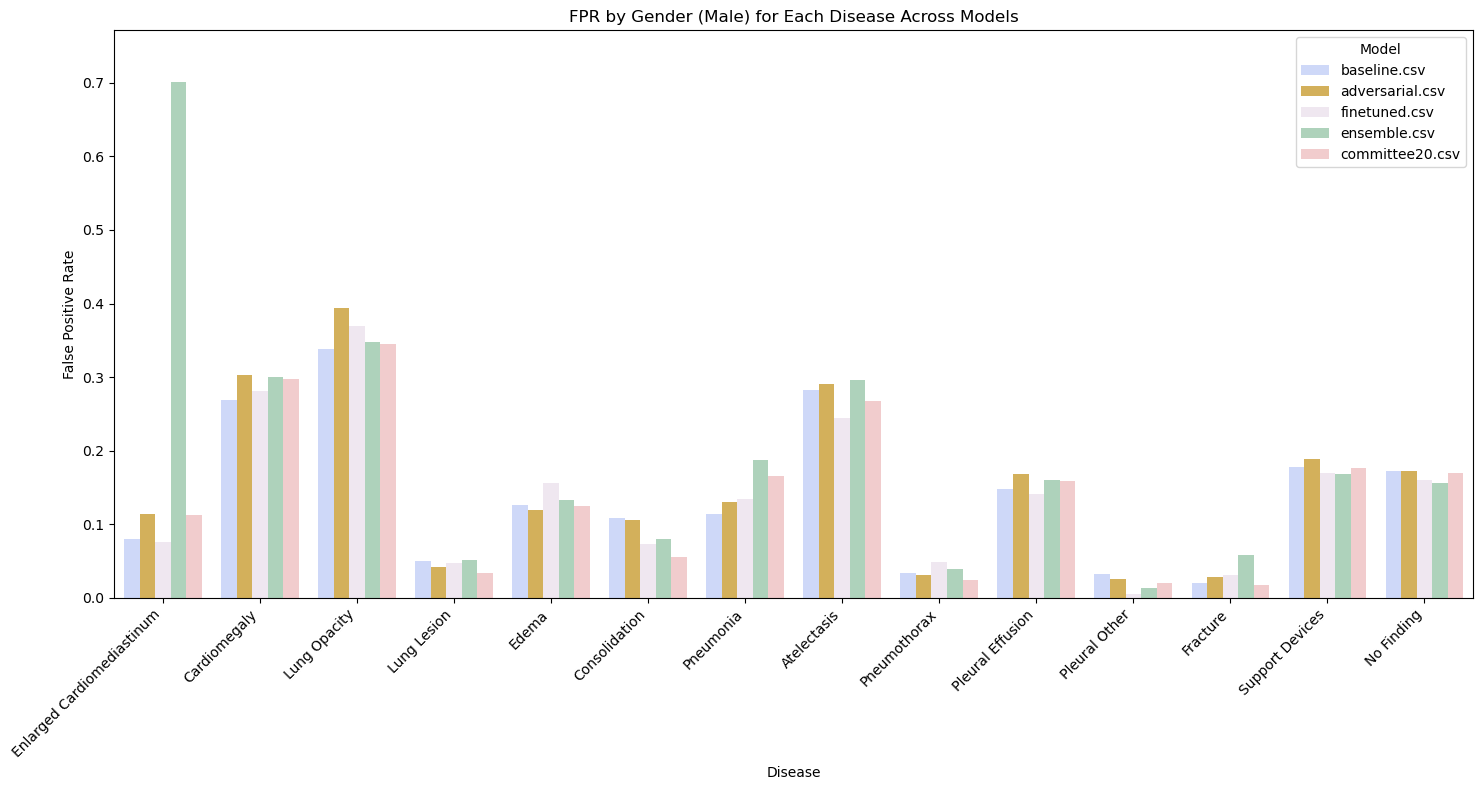

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pastel_colors = ['#c7d5ff', '#e7b847', '#f0e6f1', '#a8d8b9', '#f7c6c7', '#ffd8be']

# Prepare data for plotting
plot_data = []
for disease in diseases:
    for csv_file in csv_files:
        fpr_male = fpr_data[csv_file][disease].get("M", None)
        if fpr_male is not None:
            plot_data.append({"Disease": disease, "Model": csv_file, "FPR": fpr_male})

plot_df = pd.DataFrame(plot_data)

# Determine the global max FPR value for consistent scaling
max_fpr = plot_df["FPR"].max()

# Plotting
plt.figure(figsize=(15, 8))
sns.barplot(data=plot_df, x="Disease", y="FPR", hue="Model", palette=pastel_colors)
plt.xticks(rotation=45, ha="right")
plt.title("FPR by Gender (Male) for Each Disease Across Models")
plt.ylabel("False Positive Rate")
plt.xlabel("Disease")
plt.legend(title="Model")
plt.ylim(0, max_fpr * 1.1)  
plt.tight_layout()
plt.show()


# FPR by Gender (Female) for each disease across models

In [14]:
# Print FPR values as lists for each gender
for gender in ["M", "F"]:  # M for Male, F for Female
    print(f"\nFPR Values for Gender: {gender}")
    fpr_values_by_disease = {disease: [] for disease in diseases}  # Store FPR values for printing
    for disease in diseases:
        for csv_file in csv_files:
            fpr_value = fpr_data[csv_file][disease].get(gender, None)
            fpr_values_by_disease[disease].append(fpr_value)
    
    # Print FPR values as lists for each disease
    for disease, fpr_list in fpr_values_by_disease.items():
        print(f"{disease}: {fpr_list}")


FPR Values for Gender: M
Enlarged Cardiomediastinum: [np.float64(0.07988860847619876), np.float64(0.11435036115220608), np.float64(0.07649464798537986), np.float64(0.7011574275519972), np.float64(0.11321904098859978)]
Cardiomegaly: [np.float64(0.2683187353129673), np.float64(0.30356761375774405), np.float64(0.2808160649433882), np.float64(0.29982909634693444), np.float64(0.2968382824182867)]
Lung Opacity: [np.float64(0.3380606860158311), np.float64(0.3937994722955145), np.float64(0.3691732629727353), np.float64(0.3480650835532102), np.float64(0.3453166226912929)]
Lung Lesion: [np.float64(0.050705922865013776), np.float64(0.04175275482093664), np.float64(0.04734848484848485), np.float64(0.05122245179063361), np.float64(0.03409090909090909)]
Edema: [np.float64(0.12625385802469136), np.float64(0.11940586419753087), np.float64(0.1556712962962963), np.float64(0.13329475308641975), np.float64(0.12471064814814815)]
Consolidation: [np.float64(0.109192348565356), np.float64(0.10582713425433936

/var/folders/kt/w5w6m1w927nd4t7dr10qjl840000gn/T/ipykernel_46949/676448397.py:18: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(data=plot_df, x="Disease", y="FPR", hue="Model", palette=pastel_colors)


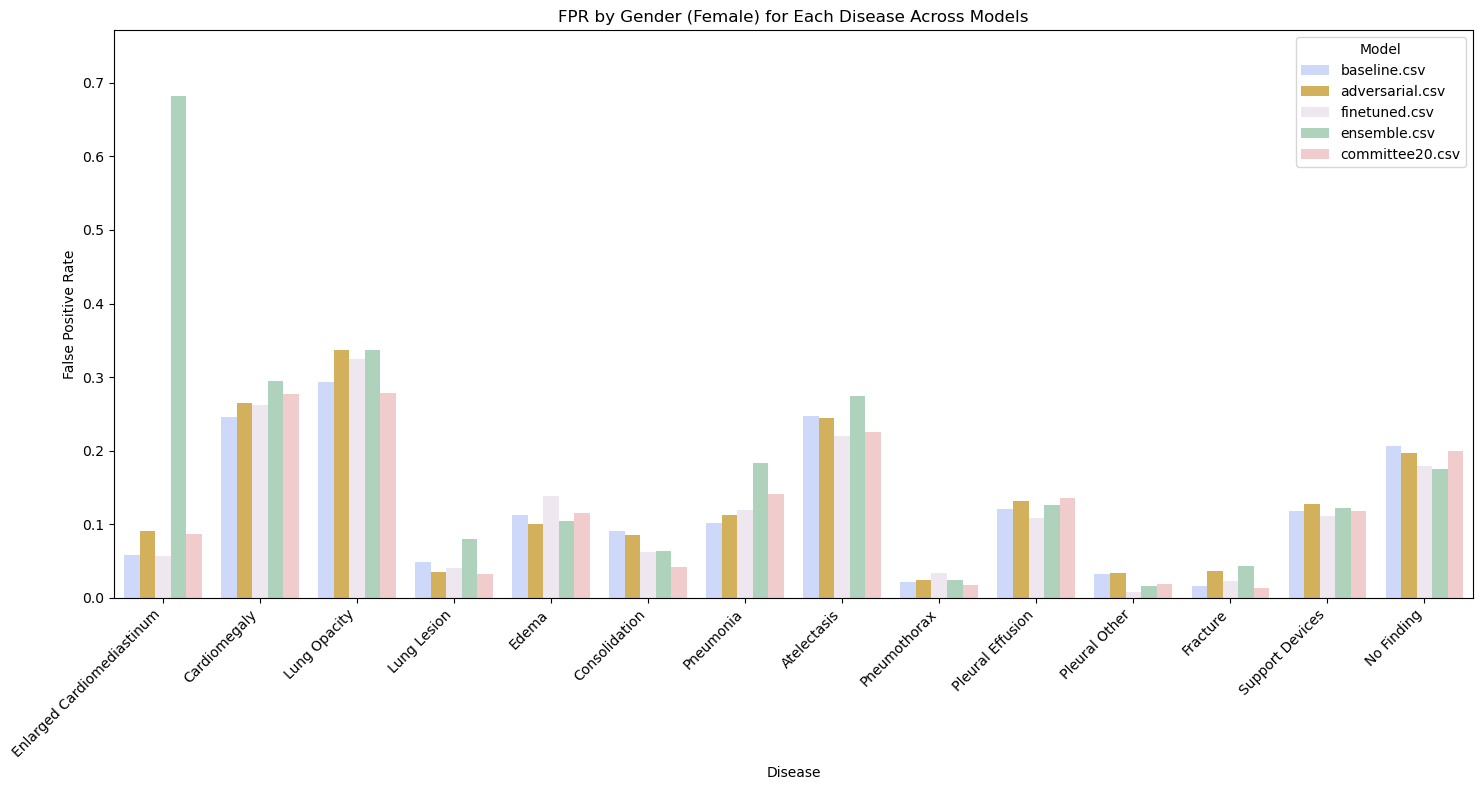

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
plot_data = []
for disease in diseases:
    for csv_file in csv_files:
        fpr_female = fpr_data[csv_file][disease].get("F", None)
        if fpr_female is not None:
            plot_data.append({"Disease": disease, "Model": csv_file, "FPR": fpr_female})

plot_df = pd.DataFrame(plot_data)

# Plotting
plt.figure(figsize=(15, 8))
sns.barplot(data=plot_df, x="Disease", y="FPR", hue="Model", palette=pastel_colors)
plt.xticks(rotation=45, ha="right")
plt.title("FPR by Gender (Female) for Each Disease Across Models")
plt.ylabel("False Positive Rate")
plt.xlabel("Disease")
plt.legend(title="Model")
plt.ylim(0, max_fpr * 1.1)  
plt.tight_layout()
plt.show()


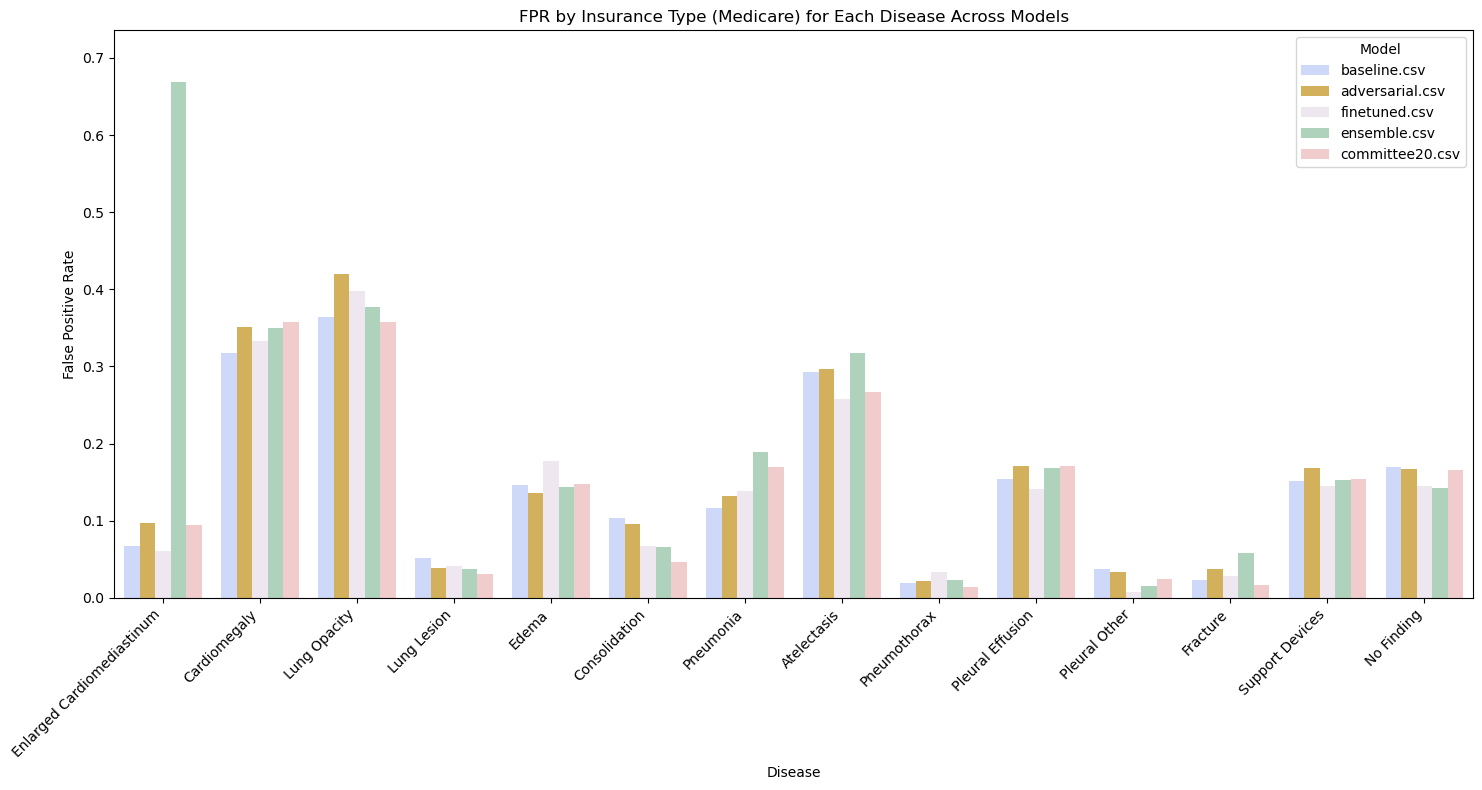

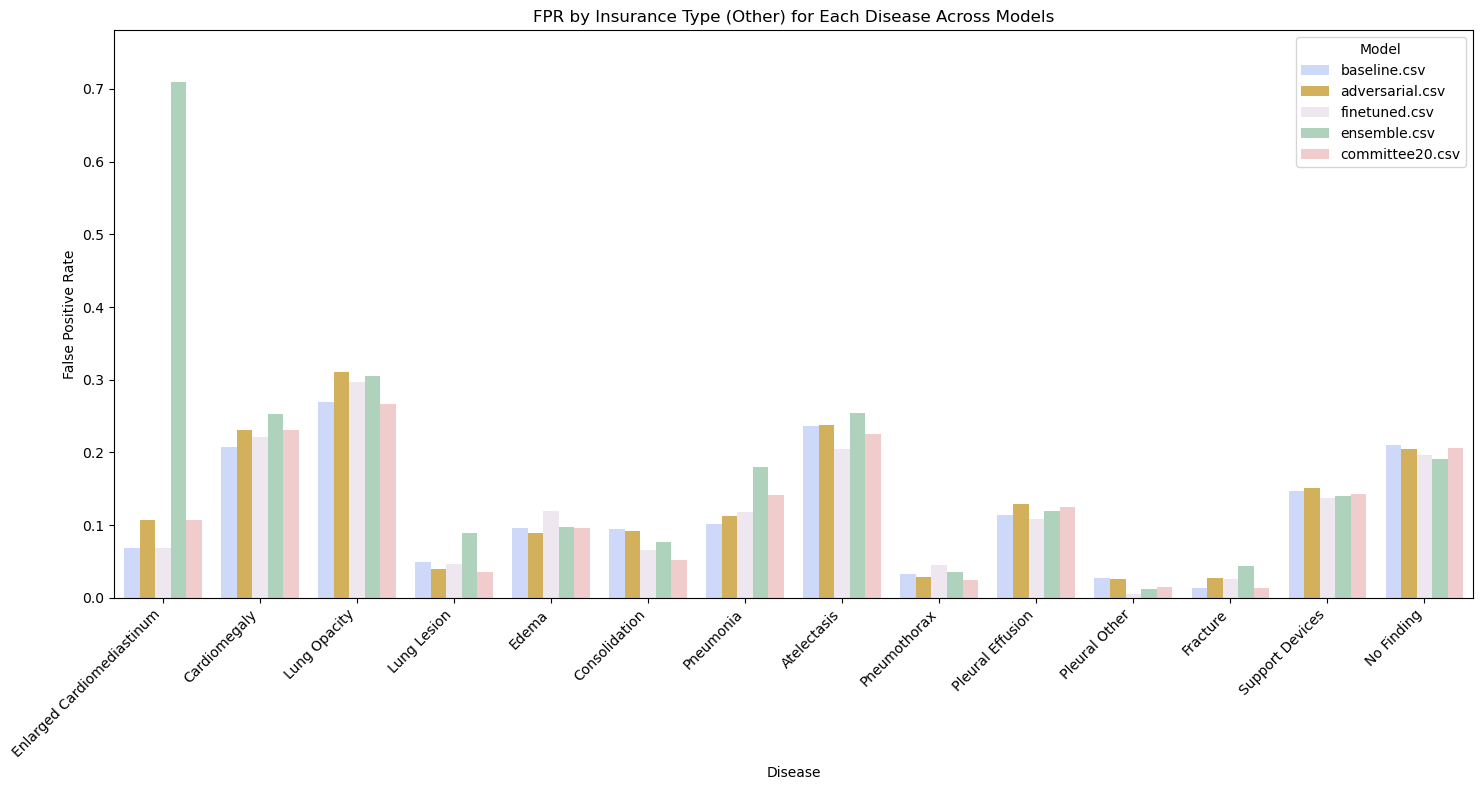

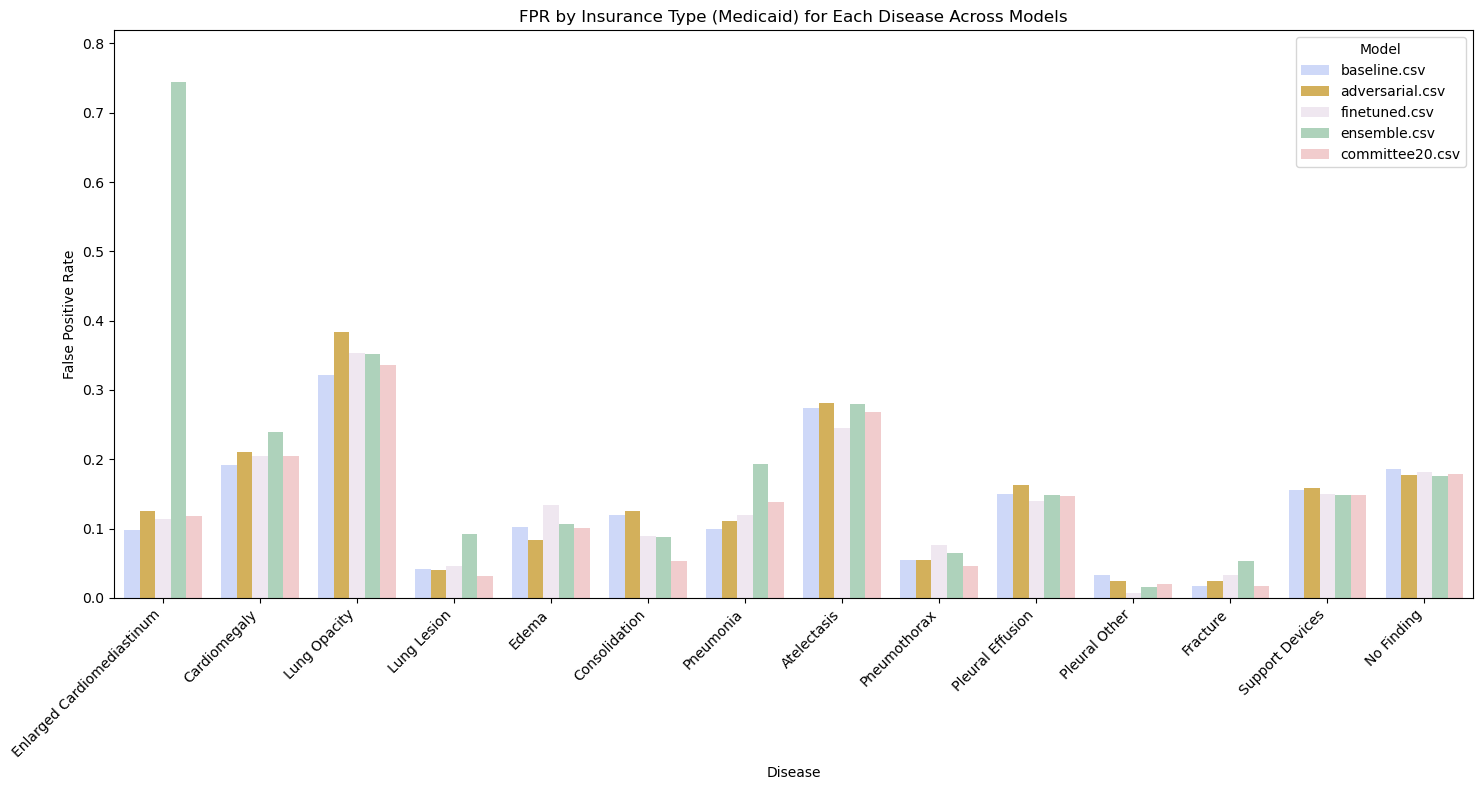

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# List of diseases
diseases = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", 
    "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax", 
    "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"
]

# List of CSV files
csv_files = ["baseline.csv", "adversarial.csv", "finetuned.csv", "ensemble.csv", "committee20.csv"]

# List of insurance types
insurance_types = ["Medicare", "Other", "Medicaid"]

#calculate FPR
def calculate_fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

# find the best threshold based on F1 score
def find_best_threshold(y_true, y_prob):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_f1 = 0
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

# calc FPR by insurance type for a specific disease
def calculate_fpr_by_insurance(df, disease):
    y_true = df[f"{disease}_ground_truth"]
    y_prob = df[f"{disease}_probability"]
    best_threshold = find_best_threshold(y_true, y_prob)
    y_pred = (y_prob >= best_threshold).astype(int)
    
    fprs = {}
    for insurance in df["insurance"].dropna().unique():
        insurance_subset = df[df["insurance"] == insurance]
        if insurance_subset[f"{disease}_ground_truth"].nunique() < 2 or insurance_subset[f"{disease}_probability"].nunique() < 2:
            fprs[insurance] = None
        else:
            y_true_insurance = insurance_subset[f"{disease}_ground_truth"]
            y_pred_insurance = (insurance_subset[f"{disease}_probability"] >= best_threshold).astype(int)
            fprs[insurance] = calculate_fpr(y_true_insurance, y_pred_insurance)
    return fprs

# Process CSV file and calc FPRs for all diseases by insurance type
def process_csv(file_path):
    df = pd.read_csv(file_path)
    fpr_results = {}
    for disease in diseases:
        fpr_results[disease] = calculate_fpr_by_insurance(df, disease)
    return fpr_results

# Process CSV files
fpr_data = {csv_file: process_csv(csv_file) for csv_file in csv_files}

# Plot FPR by insurance type for each disease across models
def plot_fpr_by_insurance(insurance_type):
    pastel_colors = ['#c7d5ff', '#e7b847', '#f0e6f1', '#a8d8b9', '#f7c6c7']
    plot_data = []
    for disease in diseases:
        for csv_file in csv_files:
            fpr_value = fpr_data[csv_file][disease].get(insurance_type, None)
            if fpr_value is not None:
                plot_data.append({"Disease": disease, "Model": csv_file, "FPR": fpr_value})
    plot_df = pd.DataFrame(plot_data)
    
    # Determine the global max FPR value for consistent scaling
    max_fpr = plot_df["FPR"].max()
    
    # Plotting
    plt.figure(figsize=(15, 8))
    sns.barplot(data=plot_df, x="Disease", y="FPR", hue="Model", palette=pastel_colors)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"FPR by Insurance Type ({insurance_type}) for Each Disease Across Models")
    plt.ylabel("False Positive Rate")
    plt.xlabel("Disease")
    plt.legend(title="Model")
    plt.ylim(0, max_fpr * 1.1)  
    plt.tight_layout()
    plt.show()

#plots for each insurance type
for insurance in insurance_types:
    plot_fpr_by_insurance(insurance)

In [17]:
# Print FPR values as lists for each insurance type
for insurance in insurance_types:
    print(f"\nFPR Values for Insurance Type: {insurance}")
    fpr_values_by_disease = {disease: [] for disease in diseases}  # Store FPR values for printing
    for disease in diseases:
        for csv_file in csv_files:
            fpr_value = fpr_data[csv_file][disease].get(insurance, None)
            fpr_values_by_disease[disease].append(fpr_value)
    
    # Print FPR values as lists for each disease
    for disease, fpr_list in fpr_values_by_disease.items():
        print(f"{disease}: {fpr_list}")


FPR Values for Insurance Type: Medicare
Enlarged Cardiomediastinum: [np.float64(0.06756490952006294), np.float64(0.09736428009441385), np.float64(0.06018882769472856), np.float64(0.6688630999213218), np.float64(0.09421715184893785)]
Cardiomegaly: [np.float64(0.31741887355464377), np.float64(0.3516100957354221), np.float64(0.33271167474822827), np.float64(0.3496207882630859), np.float64(0.3579510133034937)]
Lung Opacity: [np.float64(0.3637974683544304), np.float64(0.419493670886076), np.float64(0.39784810126582276), np.float64(0.37734177215189874), np.float64(0.3574683544303797)]
Lung Lesion: [np.float64(0.051317073170731704), np.float64(0.03814634146341463), np.float64(0.041658536585365856), np.float64(0.037073170731707315), np.float64(0.03151219512195122)]
Edema: [np.float64(0.14677656091227279), np.float64(0.1359376764141357), np.float64(0.17759963870385007), np.float64(0.14384102969402732), np.float64(0.14711527605283956)]
Consolidation: [np.float64(0.1040959040959041), np.float64(